# Алгоритм разбиения бизнесс процесса на подпроцессы по журналу событий основанный на кластеризации трасс
В данном блокноте представлен алгоритм разбиения бизнесс процесса на подпроцессы по журналу событий и его применение 
на журнале событий [BPI Challenge 2017](https://data.4tu.nl/articles/_/12696884/1).

## Оглавление:
1. Подгатовка данных
2. Применение алгоритма
3. Анализ результатов

## Подготовка данных

Для начала подключим необходимые библиотеки

In [12]:
import numpy as np
import pandas as pd
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns

Подгрузим данные. Формат журнала событий ___.xes___ и далее работать с таким форматом будет не очень удобно, поэтому преобразуем его с помощью функций библиотеки pm4py к формату ___.csv___ и сохраним в текущей директории

In [2]:
event_log_xes = pm4py.read_xes("BPI Challenge 2017.xes")
event_log_csv = pm4py.convert_to_dataframe(event_log_xes)
event_log_csv.to_csv("BPI Challenge 2017.csv", index=False)

/home/anna/.local/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
/home/anna/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 31509/31509 [00:40<00:00, 777.06it/s] 


Теперь уже откроем журнал событий с помощью pandas

In [4]:
df = pd.read_csv("BPI Challenge 2017.csv")

df.head(5)

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Стоит сразу выделить важные атрибуты данного журнала:
- case:concept:name - этот атрибут является по сути case_id - идентификатор каждого отдельного случая. В данном случае это попытка подачи заявки на кредит (случай - ее жизненый цикл одной конкретной заявки)
- concept:name - это атрибут является событием которые происходили с заявкой на протяжении ее жизни (activity)

Закодируем закодируем значения данны аттрубутов

In [6]:
code_case, unique_case = pd.factorize(df["case:concept:name"])
code_activity, unique_activity = pd.factorize(df["concept:name"])

In [7]:
print("Count of cases:", len(unique_case))
print("Count of activities:", len(unique_activity))


Count of cases: 31509
Count of activities: 26


In [13]:
df["code_case"] = code_case
df["code_activity"] = code_activity

In [14]:
grouped_df = df.groupby(df["code_case"])["code_activity"].agg(list).reset_index()

In [24]:
for_plot = df.groupby(df["code_case"])["code_activity"].count().reset_index()
for_plot = for_plot.groupby("code_activity")["code_case"].count().reset_index()

/tmp/ipykernel_36121/2050780037.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(xticks)


<Axes: xlabel='code_activity', ylabel='code_case'>

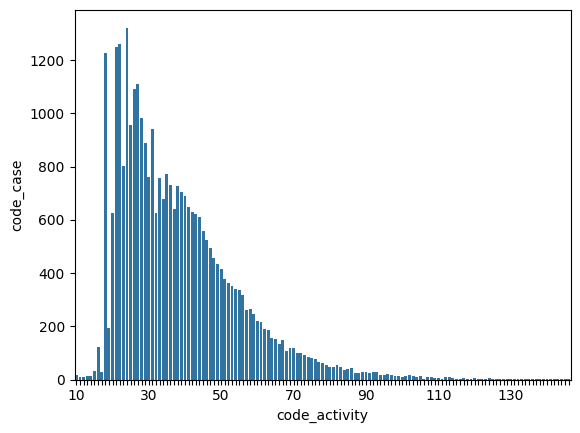

In [39]:
plot = sns.barplot(for_plot, x='code_activity', y="code_case")
cnt = 0
xticks = plot.get_xticklabels()
for i in range(len(xticks)):
    if i % 20 != 0:
        xticks[i].set_text("")
plot.set_xticklabels(xticks)

plot

In [42]:
print((for_plot["code_activity"] * for_plot["code_case"]).sum() / for_plot["code_case"].sum())

38.15630454790695


In [15]:
df_list = grouped_df.values.tolist()

## Реализация алгоритма

1) Вариант с использованием Label encoding

2) Вариант с использованием word2vec